# Surgical Site Infection (SSI) Prediction

This is a starter notebook for building and testing baseline models to predict surgical site infection (SSI).

Use this as your foundation for exploratory data analysis, model training, and interpretability.

---

In [1]:
# Install dependencies (if needed)
# !pip install pandas numpy scikit-learn matplotlib xgboost shap

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Synthetic demo dataset
np.random.seed(42)
n = 300
df = pd.DataFrame({
    'age': np.random.randint(20, 80, n),
    'bmi': np.random.normal(27, 5, n).round(1),
    'op_time': np.random.normal(120, 40, n).clip(20, 300),
    'diabetes': np.random.choice([0,1], size=n, p=[0.75, 0.25])
})
# Adjusted 'ssi' generation for a more balanced distribution
df['ssi'] = (0.01*df['age'] + 0.05*(df['bmi']>30) + 0.03*df['diabetes'] + np.random.normal(0, 0.05, n) > 0.1).astype(int)
display(df.head())

,age,bmi,op_time,diabetes,ssi
0,58,24.5,119.411270,0,1
1,71,31.6,151.856217,0,1
2,48,35.5,108.744596,0,1
3,34,31.4,53.412272,0,1
4,62,27.0,119.752034,0,1


In [4]:
# Check class balance
print("Class counts:\n", df['ssi'].value_counts())
print("Class ratio:", (df['ssi'].mean()).round(3))

# If there is only ONE class, regenerate with a more balanced target
if df['ssi'].nunique() < 2:
    print("Only one class detected. Regenerating a balanced-ish target...")
    logit = (
        -2.5                                 # tweak this to change prevalence
        + 0.02*(df['age'] - 50)
        + 0.06*(df['bmi'] - 27)
        + 0.003*(df['op_time'] - 120)
        + 0.6*df['diabetes']
    )
    p = 1/(1+np.exp(-logit))
    df['ssi'] = (np.random.rand(len(df)) < p).astype(int)
    print("New class counts:\n", df['ssi'].value_counts())

Class counts:
 ssi
1    300
Name: count, dtype: int64
Class ratio: 1.0
Only one class detected. Regenerating a balanced-ish target...
New class counts:
 ssi
0    271
1     29
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split

X = df[['age', 'bmi', 'op_time', 'diabetes']]
y = df['ssi'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train counts:\n", y_train.value_counts())
print("Test counts:\n", y_test.value_counts())


Train counts:
 ssi
0    217
1     23
Name: count, dtype: int64
Test counts:
 ssi
0    54
1     6
Name: count, dtype: int64


In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=300)
model.fit(X_train, y_train)
print("Training complete. Test accuracy:", model.score(X_test, y_test))


Training complete. Test accuracy: 0.9


ROC AUC: 0.716


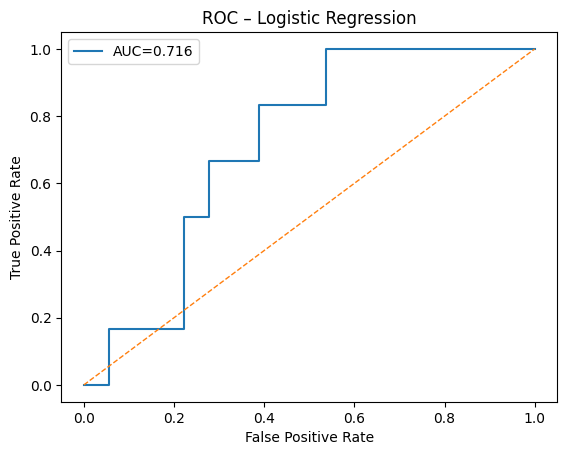

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, proba)
print("ROC AUC:", round(auc, 3))

fpr, tpr, _ = roc_curve(y_test, proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC – Logistic Regression")
import os; os.makedirs("reports/figures", exist_ok=True)
plt.savefig("reports/figures/roc.png", dpi=160, bbox_inches="tight")
plt.legend(); plt.show()
